# Coursera - Capstone Project for IBM Data Science Certificate
### "The battle of the neighborhoods"  **by Mojtaba Ghoraishy



**Objective:**
discover the best neighborhood in Dubai for opening a new Mexican restaurant.


**Data Sources:** (csv file of Dubai Neighborhood coordinates via Google Drive)

> https://drive.google.com/file/d/1skreyTFfq9Nh4Dn94omudkBHy42L8KML/view?usp=sharing

**Table of contents:**

*   **System & Data Setup**
*   **Part 1** - Create initial table with 103 postal codes ('Postcode', 'Borough','Neighborhood')
*   **Part 2** - Setup Dubai Neighborhood map using folium & 'Latititude', 'Longitude' from csv
*   **Part 3** - Venue clustering by neighborhood and analysis of 'best' fit for new location

## System & Data Setup

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

#mapping tools
!pip install geopy 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install folium
import folium # map rendering library

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

**be sure to load 'Dubai_neighborhoods.csv' into your working directory**

In [33]:
import os
cwd = os.getcwd()
cwd

'/Users/mojtaba/Desktop/projects/Coursera_Capstone.'

In [34]:
# read csv file once loaded into working directory listed above
Geospacial_Coordinates = pd.read_csv('Dubai_neighborhoods.csv', sep = ',') 
# examine the shape of original input data
print(Geospacial_Coordinates.shape)

(23, 8)


## Part 2 - Setup Dubai Neighborhood Map

In [35]:
import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [36]:
Geo = pd.DataFrame(Geospacial_Coordinates)
Geo.head()

,Neighborhood,Avg Rent Per Unit,Z-Score,Distance from Palm,Distance from Zabeel,Distance from Jumeirah,Latitude,Longitude
0,Discovery Gardens,"44,672",-1.53,8.18,26.15,20.73,25.0390,55.1445
1,Dubai Silicon Oasis,"54,417",-1.30,24.96,13.31,16.39,25.1279,55.3863
2,Jumeirah Village Circle,"60,068",-1.17,9.16,20.56,16.13,25.0602,55.2094
3,Dubai Sports City,"62,753",-1.10,11.36,22.32,18.28,25.0391,55.2176
4,Remraam,"67,284",-0.99,16.71,25.27,22.27,25.0014,55.2508


In [37]:
Geo.dtypes

Neighborhood               object
Avg Rent Per Unit          object
Z-Score                   float64
Distance from Palm        float64
Distance from Zabeel      float64
Distance from Jumeirah    float64
Latitude                  float64
Longitude                 float64
dtype: object

In [38]:
address = 'Dubai, UAE'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Dubai, UAE are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Dubai, UAE are 25.2047397, 55.2707065.


In [39]:
# create map of Dubai using latitude and longitude values
map_dubai = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(Geo['Latitude'], Geo['Longitude'], Geo['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_dubai)  
    
map_dubai

### Part 2a - initial neighborhood comparison using Foursquare API

In [40]:
CLIENT_ID = 'QTYIHJBWKWZSJNKEVNFPRHLRDSX3PM0UMU2Q2DCBVKMGHEKN' # my Foursquare ID
CLIENT_SECRET = '3EGHPQDUTIH3GEVNQSLNF4025CFAU4F5WO3EQWU1IOTR2ZFG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 250

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QTYIHJBWKWZSJNKEVNFPRHLRDSX3PM0UMU2Q2DCBVKMGHEKN
CLIENT_SECRET:3EGHPQDUTIH3GEVNQSLNF4025CFAU4F5WO3EQWU1IOTR2ZFG


**Let's explore 'Dubai Marina'.. that sounds like a cool spot**

In [41]:
#define objects for 'Studio District' index [15] in Geo
neighborhood_latitude = Geo.loc[15, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[15, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[15, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Dubai Marina are 25.0805, 55.1403.


**Now, let's get the top 100 venues that are in Dubai Marina within a radius of 500 meters.**

In [42]:
#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display GET request URL

'https://api.foursquare.com/v2/venues/explore?&client_id=QTYIHJBWKWZSJNKEVNFPRHLRDSX3PM0UMU2Q2DCBVKMGHEKN&client_secret=3EGHPQDUTIH3GEVNQSLNF4025CFAU4F5WO3EQWU1IOTR2ZFG&v=20180605&ll=25.0805,55.1403&radius=500&limit=250'

In [43]:
results = requests.get(url).json()
results # remove ';' if you want to see json data

{'meta': {'code': 200, 'requestId': '5ef67731d0415c07c633822e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Dubai Maryna',
  'headerFullLocation': 'Dubai Maryna, Dubai',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 87,
  'suggestedBounds': {'ne': {'lat': 25.085000004500007,
    'lng': 55.145259188937594},
   'sw': {'lat': 25.075999995499995, 'lng': 55.13534081106241}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b55699ef964a520b6e327e3',
       'name': 'Dubai Marina Walk (ممشى مرسى دبي)',
       'location': {'address': 'Dubai Marina',
        'lat': 25.081067868150225,
        'lng': 55.140873383188136,
        'labeledLatLngs': [{'label': 'display',
 

**clean the json and structure it into a *pandas* dataframe.**

In [44]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [46]:
venues = results['response']['groups'][0]['items']
    
df_Marina = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_Marina = df_Marina.loc[:, filtered_columns]

# filter the category for each row
df_Marina['venue.categories'] = df_Marina.apply(get_category_type, axis=1)

# clean columns

df_Marina.columns = [col.split(".")[-1] for col in df_Marina.columns]
df_Marina.insert(0, 'neighborhood', 'Dubai Marina')

print('{} venues were returned by Foursquare.'.format(df_Marina.shape[0]))
df_Marina.head()

87 venues were returned by Foursquare.


,neighborhood,name,categories,lat,lng
0,Dubai Marina,Dubai Marina Walk (ممشى مرسى دبي),Waterfront,25.081068,55.140873
1,Dubai Marina,Zaatar w Zeit,Breakfast Spot,25.080036,55.142305
2,Dubai Marina,Park Island برج پارك آيلاند,Residential Building (Apartment / Condo),25.082267,55.142127
3,Dubai Marina,Café Bateel,Café,25.081826,55.138066
4,Dubai Marina,Platform 3 Fitness (P3),Gym / Fitness Center,25.082352,55.141237


**create a map of the Marina district and highlight nearby venues

In [47]:
map_marina = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=15)

# add markers to map
for lat, lng, name, categories in zip(df_Marina['lat'], df_Marina['lng'], df_Marina['name'], df_Marina['categories']):
  label = '{},{}'.format(categories,name)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(map_marina) 
    
map_marina

In [48]:
marina_venues['categories'].value_counts()

NameError: name 'marina_venues' is not defined

### Let's create a similar dataframe for each neighborhood: 

**index # 9 - Al Sufouh**

In [49]:
#define objects for 'Al Soufouh' index [9] in Geo
neighborhood_latitude = Geo.loc[9, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[9, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[9, 'Neighborhood'] # neighborhood name

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
df_ASufouh = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_ASufouh = df_ASufouh.loc[:, filtered_columns]

# filter the category for each row
df_ASufouh['venue.categories'] = df_ASufouh.apply(get_category_type, axis=1)

# clean columns

df_ASufouh.columns = [col.split(".")[-1] for col in df_ASufouh.columns]
df_ASufouh.insert(0, 'neighborhood', 'Al Sufouh')

print('{} venues were returned by Foursquare.'.format(df_ASufouh.shape[0]))
df_ASufouh.head()

6 venues were returned by Foursquare.


,neighborhood,name,categories,lat,lng
0,Al Sufouh,Starbucks,Coffee Shop,25.111718,55.175147
1,Al Sufouh,Emirates Co-Op,Grocery Store,25.112435,55.173827
2,Al Sufouh,Shaikhath Al Arab Cafeteria شيخة العرب كافتيريا,Cafeteria,25.112604,55.173924
3,Al Sufouh,Marina Pharmacy,Pharmacy,25.112530,55.173813
4,Al Sufouh,Al Sufouh Park,Playground,25.113393,55.171660


**index # 10 DIFC**

In [50]:
#define objects for 'DIFC' index [10] in Geo
neighborhood_latitude = Geo.loc[10, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[10, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[10, 'Neighborhood'] # neighborhood name

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
df_DIFC = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_DIFC = df_DIFC.loc[:, filtered_columns]

# filter the category for each row
df_DIFC['venue.categories'] = df_DIFC.apply(get_category_type, axis=1)

# clean columns

df_DIFC.columns = [col.split(".")[-1] for col in df_DIFC.columns]
df_DIFC.insert(0, 'neighborhood', 'DIFC')

print('{} venues were returned by Foursquare.'.format(df_DIFC.shape[0]))
df_DIFC.head()

71 venues were returned by Foursquare.


,neighborhood,name,categories,lat,lng
0,DIFC,The Sunken Garden,Hookah Bar,25.212093,55.280039
1,DIFC,Waldorf Astoria Dubai International Financial ...,Hotel,25.211310,55.281272
2,DIFC,Café Belge,Belgian Restaurant,25.212062,55.279914
3,DIFC,"The Ritz-Carlton, Dubai International Financia...",Hotel,25.213067,55.279473
4,DIFC,Burger & Lobster,Seafood Restaurant,25.211287,55.281787


**index # 11 Business Bay**

In [51]:
#define objects for 'Business_Bay' index [11] in Geo
neighborhood_latitude = Geo.loc[11, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[11, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[11, 'Neighborhood'] # neighborhood name

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
df_Business_Bay = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_Business_Bay = df_Business_Bay.loc[:, filtered_columns]

# filter the category for each row
df_Business_Bay['venue.categories'] = df_Business_Bay.apply(get_category_type, axis=1)

# clean columns

df_Business_Bay.columns = [col.split(".")[-1] for col in df_Business_Bay.columns]
df_Business_Bay.insert(0, 'neighborhood', 'Business Bay')

print('{} venues were returned by Foursquare.'.format(df_Business_Bay.shape[0]))
df_Business_Bay.head()

27 venues were returned by Foursquare.


,neighborhood,name,categories,lat,lng
0,Business Bay,Gulf Court Hotel Business Bay,Hotel,25.182244,55.274908
1,Business Bay,Long Teng Seafood Restaurant,Chinese Restaurant,25.181090,55.271401
2,Business Bay,Basta!,Italian Restaurant,25.185432,55.273593
3,Business Bay,"Renaissance Downtown Hotel, Dubai",Hotel,25.185822,55.273564
4,Business Bay,Grounded,Coffee Shop,25.185531,55.273516


**index # 12 Jumeirah Lakes Towers**

In [52]:
#define objects for 'JLT' index [12] in Geo
neighborhood_latitude = Geo.loc[12, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[12, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[12, 'Neighborhood'] # neighborhood name

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
df_JLT = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_JLT = df_JLT.loc[:, filtered_columns]

# filter the category for each row
df_JLT['venue.categories'] = df_JLT.apply(get_category_type, axis=1)

# clean columns

df_JLT.columns = [col.split(".")[-1] for col in df_JLT.columns]
df_JLT.insert(0, 'neighborhood', 'Jumeirah Lakes Towers')

print('{} venues were returned by Foursquare.'.format(df_JLT.shape[0]))
df_JLT.head()

27 venues were returned by Foursquare.


,neighborhood,name,categories,lat,lng
0,Jumeirah Lakes Towers,Bait Maryam,Theme Restaurant,25.070765,55.141889
1,Jumeirah Lakes Towers,Wokyo Noodle Bar,Noodle House,25.068151,55.140931
2,Jumeirah Lakes Towers,Fidelity Fitness Club,Gym,25.068784,55.141660
3,Jumeirah Lakes Towers,Betawi,Indonesian Restaurant,25.069993,55.141876
4,Jumeirah Lakes Towers,Chaps&Co,Health & Beauty Service,25.068466,55.140135


**index 13 Barsha Heights**

In [53]:
#define objects for 'Barsha' index [12] in Geo
neighborhood_latitude = Geo.loc[13, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[13, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[13, 'Neighborhood'] # neighborhood name

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
df_Barsha = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_Barsha = df_Barsha.loc[:, filtered_columns]

# filter the category for each row
df_Barsha['venue.categories'] = df_Barsha.apply(get_category_type, axis=1)

# clean columns

df_Barsha.columns = [col.split(".")[-1] for col in df_Barsha.columns]
df_Barsha.insert(0, 'neighborhood', 'Barsha Heights')

print('{} venues were returned by Foursquare.'.format(df_Barsha.shape[0]))
df_Barsha.head()

61 venues were returned by Foursquare.


,neighborhood,name,categories,lat,lng
0,Barsha Heights,AURIS INN Al MUHANNA Hotel,Hotel,25.094750,55.177058
1,Barsha Heights,Beef King,Chinese Restaurant,25.096673,55.175715
2,Barsha Heights,Fuchsia,Thai Restaurant,25.095363,55.178584
3,Barsha Heights,TRYP by Wyndham Dubai,Hotel,25.097234,55.174834
4,Barsha Heights,MMA Fitness Center,Gym / Fitness Center,25.096647,55.175727


**analysis of venue distribution**

In [54]:
df_venues = pd.concat([df_Barsha, df_JLT, df_Business_Bay, df_DIFC, df_Marina, df_ASufouh])
df_venues['count'] = 1
df_venues.shape

(279, 6)

In [55]:
total_venues = pd.pivot_table(df_venues,index=["neighborhood"], values=["count"],aggfunc=np.sum)
total_venues

,count
neighborhood,
Al Sufouh,6
Barsha Heights,61
Business Bay,27
DIFC,71
Dubai Marina,87
Jumeirah Lakes Towers,27


In [56]:
df_venues2 = df_venues.copy()
df_venues3 = df_venues.copy()
df_venues_rest = df_venues2[df_venues2['categories'].str.contains('Restaurant')].reset_index(drop=True)
df_venues_rest['Venue Type'] = 'Restaurant'
df_venues_hotel = df_venues3[df_venues3['categories'].str.contains('Hotel')].reset_index(drop=True)
df_venues_hotel['Venue Type'] = 'Hotel'
df_venues_final = pd.concat([df_venues_rest,df_venues_hotel]).reset_index(drop=True)
df_venues_final.shape

(119, 7)

In [57]:
pivot = pd.pivot_table(df_venues_final,index=["neighborhood","Venue Type"], values=["count"],aggfunc=np.sum)
pivot

count
neighborhood          Venue Type       
Barsha Heights        Hotel          18
                      Restaurant     15
Business Bay          Hotel           4
                      Restaurant     11
DIFC                  Hotel           5
                      Restaurant     20
Dubai Marina          Hotel           9
                      Restaurant     26
Jumeirah Lakes Towers Hotel           1
                      Restaurant     10

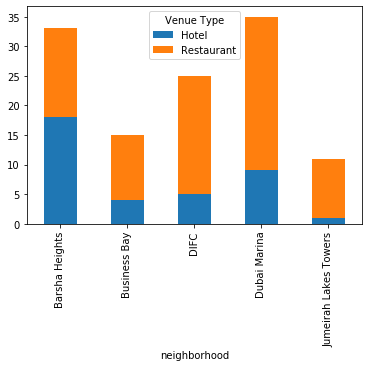

In [58]:
df_venues_final.groupby('neighborhood')['Venue Type']\
    .value_counts()\
    .unstack(level=1)\
    .plot.bar(stacked=True)

**create 'one hot' file with dummy values by venue category**

In [59]:
# one hot encoding
dubai_onehot = pd.get_dummies(df_venues_final[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dubai_onehot['neighborhood'] = df_venues_final['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dubai_onehot.columns[-1]] + list(dubai_onehot.columns[:-1])
dubai_onehot = dubai_onehot[fixed_columns]

dubai_onehot.head()

,neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Eastern European Restaurant,English Restaurant,Fast Food Restaurant,...,Modern European Restaurant,Peruvian Restaurant,Restaurant,Seafood Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vietnamese Restaurant
0,Barsha Heights,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barsha Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Barsha Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barsha Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barsha Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [60]:
dubai_grouped = dubai_onehot.groupby('neighborhood').mean().reset_index()
dubai_grouped

,neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Eastern European Restaurant,English Restaurant,Fast Food Restaurant,...,Modern European Restaurant,Peruvian Restaurant,Restaurant,Seafood Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vietnamese Restaurant
0,Barsha Heights,0.000000,0.000000,0.00,0.000000,0.030303,0.030303,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.030303,0.000000,0.030303,0.000000
1,Business Bay,0.000000,0.000000,0.00,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.066667,0.00,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000
2,DIFC,0.000000,0.080000,0.04,0.000000,0.000000,0.000000,0.000000,0.040000,0.040000,...,0.000000,0.04,0.040000,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Dubai Marina,0.028571,0.142857,0.00,0.057143,0.028571,0.000000,0.028571,0.028571,0.028571,...,0.028571,0.00,0.057143,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Jumeirah Lakes Towers,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.090909,0.00,0.000000,0.00,0.000000,0.000000,0.090909,0.090909,0.000000,0.181818


In [61]:
dubai_grouped.shape

(5, 34)

**Let's print each neighborhood along with the top 5 most common venues**

In [62]:
num_top_venues = 5

for hood in dubai_grouped['neighborhood']:
    print("----"+hood+"----")
    temp = dubai_grouped[dubai_grouped['neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barsha Heights----
                       venue  freq
0                      Hotel  0.48
1  Middle Eastern Restaurant  0.15
2         Italian Restaurant  0.06
3                  Hotel Bar  0.06
4        Lebanese Restaurant  0.03


----Business Bay----
                       venue  freq
0                      Hotel  0.27
1         Italian Restaurant  0.13
2  Middle Eastern Restaurant  0.13
3          French Restaurant  0.07
4          Syrian Restaurant  0.07


----DIFC----
                       venue  freq
0                      Hotel  0.20
1         Italian Restaurant  0.16
2  Middle Eastern Restaurant  0.08
3           Asian Restaurant  0.08
4          Indian Restaurant  0.08


----Dubai Marina----
                       venue  freq
0                      Hotel  0.23
1           Asian Restaurant  0.14
2         Italian Restaurant  0.11
3  Middle Eastern Restaurant  0.09
4       Caribbean Restaurant  0.06


----Jumeirah Lakes Towers----
                   venue  freq
0  Vietnamese

**First, let's write a function to sort the venues in descending order.**

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [64]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = dubai_grouped['neighborhood']

for ind in np.arange(dubai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dubai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Barsha Heights,Hotel,Middle Eastern Restaurant,Hotel Bar,Italian Restaurant,Mexican Restaurant
1,Business Bay,Hotel,Italian Restaurant,Middle Eastern Restaurant,German Restaurant,French Restaurant
2,DIFC,Hotel,Italian Restaurant,Indian Restaurant,Middle Eastern Restaurant,Asian Restaurant
3,Dubai Marina,Hotel,Asian Restaurant,Italian Restaurant,Middle Eastern Restaurant,Caribbean Restaurant
4,Jumeirah Lakes Towers,Vietnamese Restaurant,Indian Restaurant,Modern European Restaurant,Greek Restaurant,Hotel


In [65]:
#define objects for 'DIFC' index [10] in Geo
neighborhood_latitude = Geo.loc[10, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Geo.loc[10, 'Longitude'] # neighborhood longitude value
neighborhood_name = Geo.loc[10, 'Neighborhood'] # neighborhood name

map_DIFC = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=15)

# add markers to map
for lat, lng, name, categories in zip(df_DIFC['lat'], df_DIFC['lng'], df_DIFC['name'], df_DIFC['categories']):
  label = '{},{}'.format(categories,name)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(map_DIFC) 
    
map_DIFC